In [ ]:
! pip install cryptocmd
! pip install git+git://github.com/guptarohit/cryptoCMD.git

     |████████████████████████████████| 48 kB 1.9 MB/s 
  Cloning git://github.com/guptarohit/cryptoCMD.git to /tmp/pip-req-build-13_23ob9
  Running command git clone -q git://github.com/guptarohit/cryptoCMD.git /tmp/pip-req-build-13_23ob9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
start = "2015-08-01"#'2017-01-01'
end = "2021-01-01"#'2019-11-23'

In [ ]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import re
from cryptocmd import CmcScraper
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
scraper = CmcScraper('BTC',"01-08-2015","01-01-2021") # initialise scraper without passing time interv
headers, data = scraper.get_data()
#scraper.export_csv('btc_all_time.csv')   
df_price = scraper.get_dataframe().sort_index(ascending=False)
price=df_price["Close"].values.tolist()

df_price=df_price.reset_index().drop(["index"],axis=1)

In [ ]:
price=df_price.Close.to_list()
price_o=df_price.Open.to_list()

In [ ]:
df_price

,Date,Open,High,Low,Close,Volume,Market Cap
0,2015-08-01,284.686005,284.932007,278.112000,281.601013,1.899500e+07,4.069120e+09
1,2015-08-02,280.449005,283.032013,277.528992,282.614014,1.772220e+07,4.084832e+09
2,2015-08-03,282.806000,285.471008,280.233002,281.226990,2.147410e+07,4.065896e+09
3,2015-08-04,281.225006,285.714996,281.225006,285.217987,2.190870e+07,4.124559e+09
4,2015-08-05,284.846985,285.501007,281.488007,281.881989,2.012800e+07,4.077254e+09
...,...,...,...,...,...,...,...
1976,2020-12-28,26280.821415,27389.112064,26207.639931,27084.807886,4.905674e+10,5.033393e+11
1977,2020-12-29,27081.809729,27370.720084,25987.298075,27362.436557,4.526595e+10,5.085237e+11
1978,2020-12-30,27360.089709,28937.740004,27360.089709,28840.953420,5.128744e+10,5.360338e+11
1979,2020-12-31,28841.573758,29244.876688,28201.991994,29001.719822,4.675496e+10,5.390511e+11


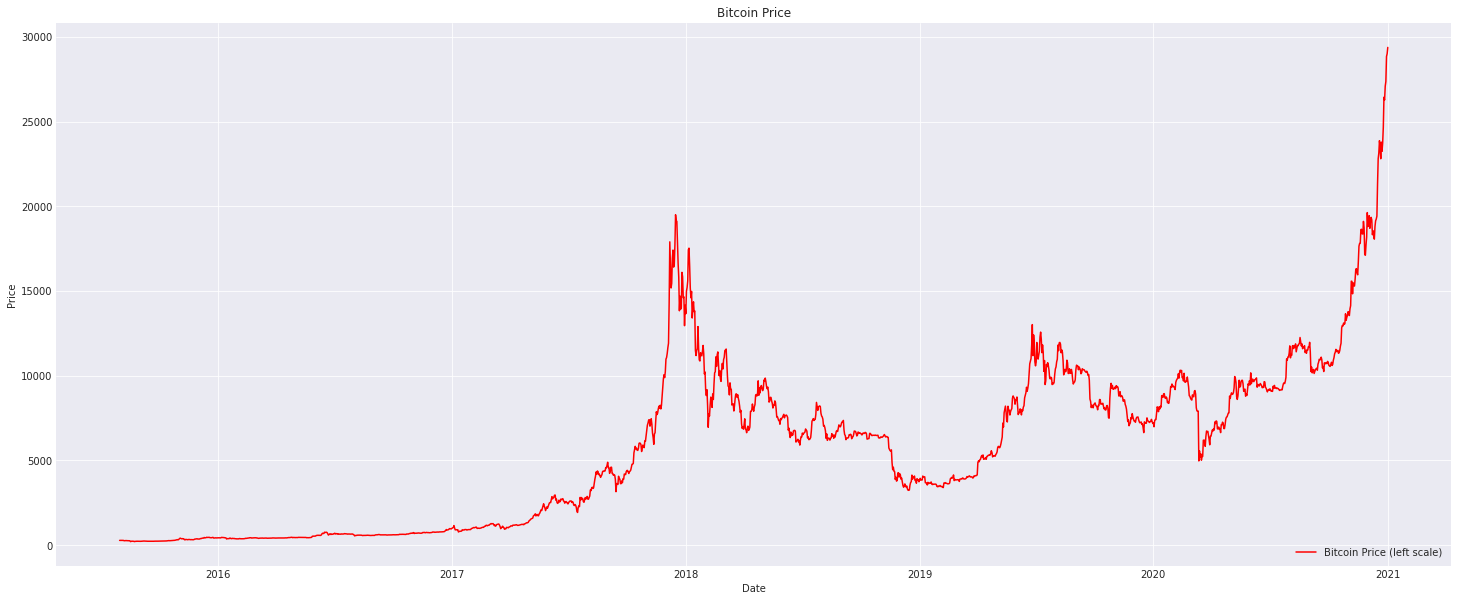

In [ ]:
import datetime as dt
import matplotlib.dates as mdates
dates = df_price[0:len(df_price["Date"])]["Date"]
x = dates#[dt.datetime.strptime(d,'%Y/%m/%d').date() for d in dates]

fig, ax1 = plt.subplots(figsize=(25,10))
ax1.plot(x,price, label='Bitcoin Price (left scale)', color='r')

ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

ax1.legend(loc=4)
ax1.set_title("Bitcoin Price")

plt.show()

#Google Trend

In [ ]:
!pip install pytrends

from datetime import datetime, timedelta, date, time
import pandas as pd
import time
from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError
import numpy as np
import matplotlib.pyplot as plt


def _fetch_data(trendreq, kw_list, timeframe='today 3-m', cat=0, geo='', gprop='') -> pd.DataFrame:
    
    """Download google trends data using pytrends TrendReq and retries in case of a ResponseError."""
    attempts, fetched = 0, False
    while not fetched:
        try:
            trendreq.build_payload(kw_list=kw_list, timeframe=timeframe, cat=cat, geo=geo, gprop=gprop)
        except ResponseError as err:
            print(err)
            print(f'Trying again in {60 + 5 * attempts} seconds.')
            sleep(60 + 5 * attempts)
            attempts += 1
            if attempts > 3:
                print('Failed after 3 attemps, abort fetching.')
                break
        else:
            fetched = True
    return trendreq.interest_over_time()

def get_daily_trend(trendreq, keyword:str, start:str, end:str, cat=0, 
                    geo='', gprop='', delta=269, overlap=100, sleep=0, 
                    tz=0, verbose=False) ->pd.DataFrame:

    """Stich and scale consecutive daily trends data between start and end date.
    This function will first download piece-wise google trends data and then 
    scale each piece using the overlapped period. 
        Parameters
        ----------
        trendreq : TrendReq
            a pytrends TrendReq object
        keyword: str
            currently only support single keyword, without bracket
        start: str
            starting date in string format:YYYY-MM-DD (e.g.2017-02-19)
        end: str
            ending date in string format:YYYY-MM-DD (e.g.2017-02-19)
        cat, geo, gprop, sleep: 
            same as defined in pytrends
        delta: int
            The length(days) of each timeframe fragment for fetching google trends data, 
            need to be <269 in order to obtain daily data.
        overlap: int
            The length(days) of the overlap period used for scaling/normalization
        tz: int
            The timezone shift in minute relative to the UTC+0 (google trends default).
            For example, correcting for UTC+8 is 480, and UTC-6 is -360 
    """
    
    start_d = datetime.strptime(start, '%Y-%m-%d')
    init_end_d = end_d = datetime.strptime(end, '%Y-%m-%d')
    init_end_d.replace(hour=23, minute=59, second=59)    
    delta = timedelta(days=delta)
    overlap = timedelta(days=overlap)

    itr_d = end_d - delta
    overlap_start = None

    df = pd.DataFrame()
    ol = pd.DataFrame()
    
    while end_d > start_d:
        tf = itr_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')
        if verbose: print('Fetching \''+keyword+'\' for period:'+tf)
        temp = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        temp.drop(columns=['isPartial'], inplace=True)
        temp.columns.values[0] = tf
        ol_temp = temp.copy()
        ol_temp.iloc[:,:] = None
        if overlap_start is not None:  # not first iteration
            if verbose: print('Normalize by overlapping period:'+overlap_start.strftime('%Y-%m-%d'), end_d.strftime('%Y-%m-%d'))
            #normalize using the maximum value of the overlapped period
            y1 = temp.loc[overlap_start:end_d].iloc[:,0].values.max()
            y2 = df.loc[overlap_start:end_d].iloc[:,-1].values.max()
            coef = y2/y1
            temp = temp * coef
            ol_temp.loc[overlap_start:end_d, :] = 1 

        df = pd.concat([df,temp], axis=1)
        ol = pd.concat([ol, ol_temp], axis=1)
        # shift the timeframe for next iteration
        overlap_start = itr_d
        end_d -= (delta-overlap)
        itr_d -= (delta-overlap)
        # in case of short query interval getting banned by server
        time.sleep(sleep)
    
    df.sort_index(inplace=True)
    ol.sort_index(inplace=True)
    #The daily trend data is missing the most recent 3-days data, need to complete with hourly data
    if df.index.max() < init_end_d : 
        tf = 'now 7-d'
        hourly = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        hourly.drop(columns=['isPartial'], inplace=True)
        
        #convert hourly data to daily data
        daily = hourly.groupby(hourly.index.date).sum()
        
        #check whether the first day data is complete (i.e. has 24 hours)
        daily['hours'] = hourly.groupby(hourly.index.date).count()
        if daily.iloc[0].loc['hours'] != 24: daily.drop(daily.index[0], inplace=True)
        daily.drop(columns='hours', inplace=True)
        
        daily.set_index(pd.DatetimeIndex(daily.index), inplace=True)
        daily.columns = [tf]
        
        ol_temp = daily.copy()
        ol_temp.iloc[:,:] = None
        # find the overlapping date
        intersect = df.index.intersection(daily.index)
        if verbose: print('Normalize by overlapping period:'+(intersect.min().strftime('%Y-%m-%d'))+' '+(intersect.max().strftime('%Y-%m-%d')))
        # scaling use the overlapped today-4 to today-7 data
        coef = df.loc[intersect].iloc[:,0].max() / daily.loc[intersect].iloc[:,0].max()
        daily = (daily*coef).round(decimals=0)
        ol_temp.loc[intersect,:] = 1
        
        df = pd.concat([daily, df], axis=1)
        ol = pd.concat([ol_temp, ol], axis=1)

    # taking averages for overlapped period
    df = df.mean(axis=1)
    ol = ol.max(axis=1)
    # merge the two dataframe (trend data and overlap flag)
    df = pd.concat([df,ol], axis=1)
    df.columns = [keyword,'overlap']
    # Correct the timezone difference
    df.index = df.index + timedelta(minutes=tz)
    df = df[start_d:init_end_d]
    # re-normalized to the overall maximum value to have max =100
    df[keyword] = (100*df[keyword]/df[keyword].max()).round(decimals=0)
    
    return df

In [ ]:
import matplotlib
plt.style.use('seaborn-darkgrid')
matplotlib.rcParams['font.family'] = ['Heiti TC']
def rmax(maxrow: int=50):
    pd.set_option('display.max_rows', maxrow)

def cmax(maxcol: int=50):
    pd.set_option('display.max_columns', maxcol)

In [ ]:
pytrend = TrendReq(hl='en-US')
keyword = 'Bitcoin'
start = start
end = end
geo='US'
cat=0
gprop=''

In [ ]:
overlapping = get_daily_trend(pytrend, keyword, start, end, geo=geo, cat=cat, gprop=gprop, verbose=True, tz=0)

Fetching 'Bitcoin' for period:2020-04-07 2021-01-01
Fetching 'Bitcoin' for period:2019-10-21 2020-07-16
Normalize by overlapping period:2020-04-07 2020-07-16
Fetching 'Bitcoin' for period:2019-05-05 2020-01-29
Normalize by overlapping period:2019-10-21 2020-01-29
Fetching 'Bitcoin' for period:2018-11-17 2019-08-13
Normalize by overlapping period:2019-05-05 2019-08-13
Fetching 'Bitcoin' for period:2018-06-01 2019-02-25
Normalize by overlapping period:2018-11-17 2019-02-25
Fetching 'Bitcoin' for period:2017-12-14 2018-09-09
Normalize by overlapping period:2018-06-01 2018-09-09
Fetching 'Bitcoin' for period:2017-06-28 2018-03-24
Normalize by overlapping period:2017-12-14 2018-03-24
Fetching 'Bitcoin' for period:2017-01-10 2017-10-06
Normalize by overlapping period:2017-06-28 2017-10-06
Fetching 'Bitcoin' for period:2016-07-25 2017-04-20
Normalize by overlapping period:2017-01-10 2017-04-20
Fetching 'Bitcoin' for period:2016-02-07 2016-11-02
Normalize by overlapping period:2016-07-25 2016-

In [ ]:
google_trend=overlapping.drop(["overlap"],axis=1)

In [ ]:
google_trend.to_csv("google.csv")

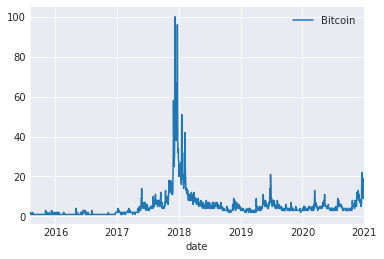

In [ ]:
google_trend.plot()

#WIKIPEDIA

In [ ]:
wiki_total=pd.read_csv("https://raw.githubusercontent.com/fionajiayi/SRS2021/main/wiki_bitcoin.csv")

In [ ]:
left=wiki_total.loc[wiki_total["Date"] == start].index.tolist()[0]
right=wiki_total.loc[wiki_total["Date"] == end].index.tolist()[0]
wiki=wiki_total[left:right+1].reset_index().drop(["index"],axis=1)

In [ ]:
wiki.to_csv("wiki.csv")

In [ ]:
wiki.tail()
df=pd.concat([google_trend["Bitcoin"],wiki["Bitcoin"]],axis=1)

In [ ]:
import datetime as dt

a=google_trend["Bitcoin"].to_list()
b=wiki["Bitcoin"].to_list()
dates = wiki["Date"]
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]

data = {"date":x,'google_trend': a,
        'wiki': b,"price":price,"open_price":price_o}

df = pd.DataFrame(data,columns=["date",'google_trend','wiki',"price","open_price"])
df.to_csv("replication2.csv")

In [ ]:
df["log_return"]=np.log(df["price"])-np.log(df["open_price"])

In [ ]:
df.to_csv("replication2.csv")

#Wavelet Coherence

In [ ]:
from matplotlib.pyplot import *

In [ ]:
!pip install git+https://github.com/mabelcalim/waipy.git

  Cloning https://github.com/mabelcalim/waipy.git to /tmp/pip-req-build-k4_mfods
  Running command git clone -q https://github.com/mabelcalim/waipy.git /tmp/pip-req-build-k4_mfods
  Created wheel for waipy: filename=waipy-0.0.1.51-py3-none-any.whl size=16830 sha256=04c51622963916fb71b43f52cc2283949c16ec634228eb4fa272f2495b597246
  Stored in directory: /tmp/pip-ephem-wheel-cache-0m8ugx3u/wheels/e2/c8/2d/4ae7944b0bcb25a2150573c157d8aea7d7a115694adb0f0f76
Successfully built waipy


In [ ]:
import waipy
import math

In [ ]:
data=df["log_return"]

In [ ]:
time = np.arange(0, len(data))

In [ ]:
data_norm = waipy.normalize(data)

In [ ]:
alpha = np.corrcoef(data[0:-1], data_norm[1:])[0,1]; 
print("Lag-1 autocorrelation = {:4.2f}".format(alpha))

Lag-1 autocorrelation = -0.02


In [ ]:
result = waipy.cwt(data_norm, 1, 1, 0.25, 2, 4/0.25, alpha, 6, mother='Morlet',name="x")

Nr of Scales: 39
scales [2.0, 2.378414230005442, 2.8284271247461903, 3.363585661014858, 4.0, 4.756828460010884, 5.656854249492381, 6.727171322029716, 8.0, 9.513656920021768, 11.313708498984761, 13.454342644059432, 16.0, 19.027313840043536, 22.627416997969522, 26.908685288118864, 32.0, 38.05462768008707, 45.254833995939045, 53.81737057623773, 64.0, 76.10925536017415, 90.50966799187809, 107.63474115247546, 128.0, 152.2185107203483, 181.01933598375618, 215.2694823049509, 256.0, 304.4370214406966, 362.03867196751236, 430.5389646099018, 512.0, 608.8740428813932, 724.0773439350247, 861.0779292198037, 1024.0, 1217.7480857627863, 1448.1546878700494, 1722.1558584396073]


{'ax_cwt': <matplotlib.axes._subplots.AxesSubplot at 0x7ff44700e110>,
 'ax_data': <matplotlib.axes._subplots.AxesSubplot at 0x7ff446feb390>,
 'ax_global_spectrum': <matplotlib.axes._subplots.AxesSubplot at 0x7ff446f1a410>,
 'ax_wavelet': <matplotlib.axes._subplots.AxesSubplot at 0x7ff446ed96d0>,
 'fig': <Figure size 4500x3000 with 5 Axes>}

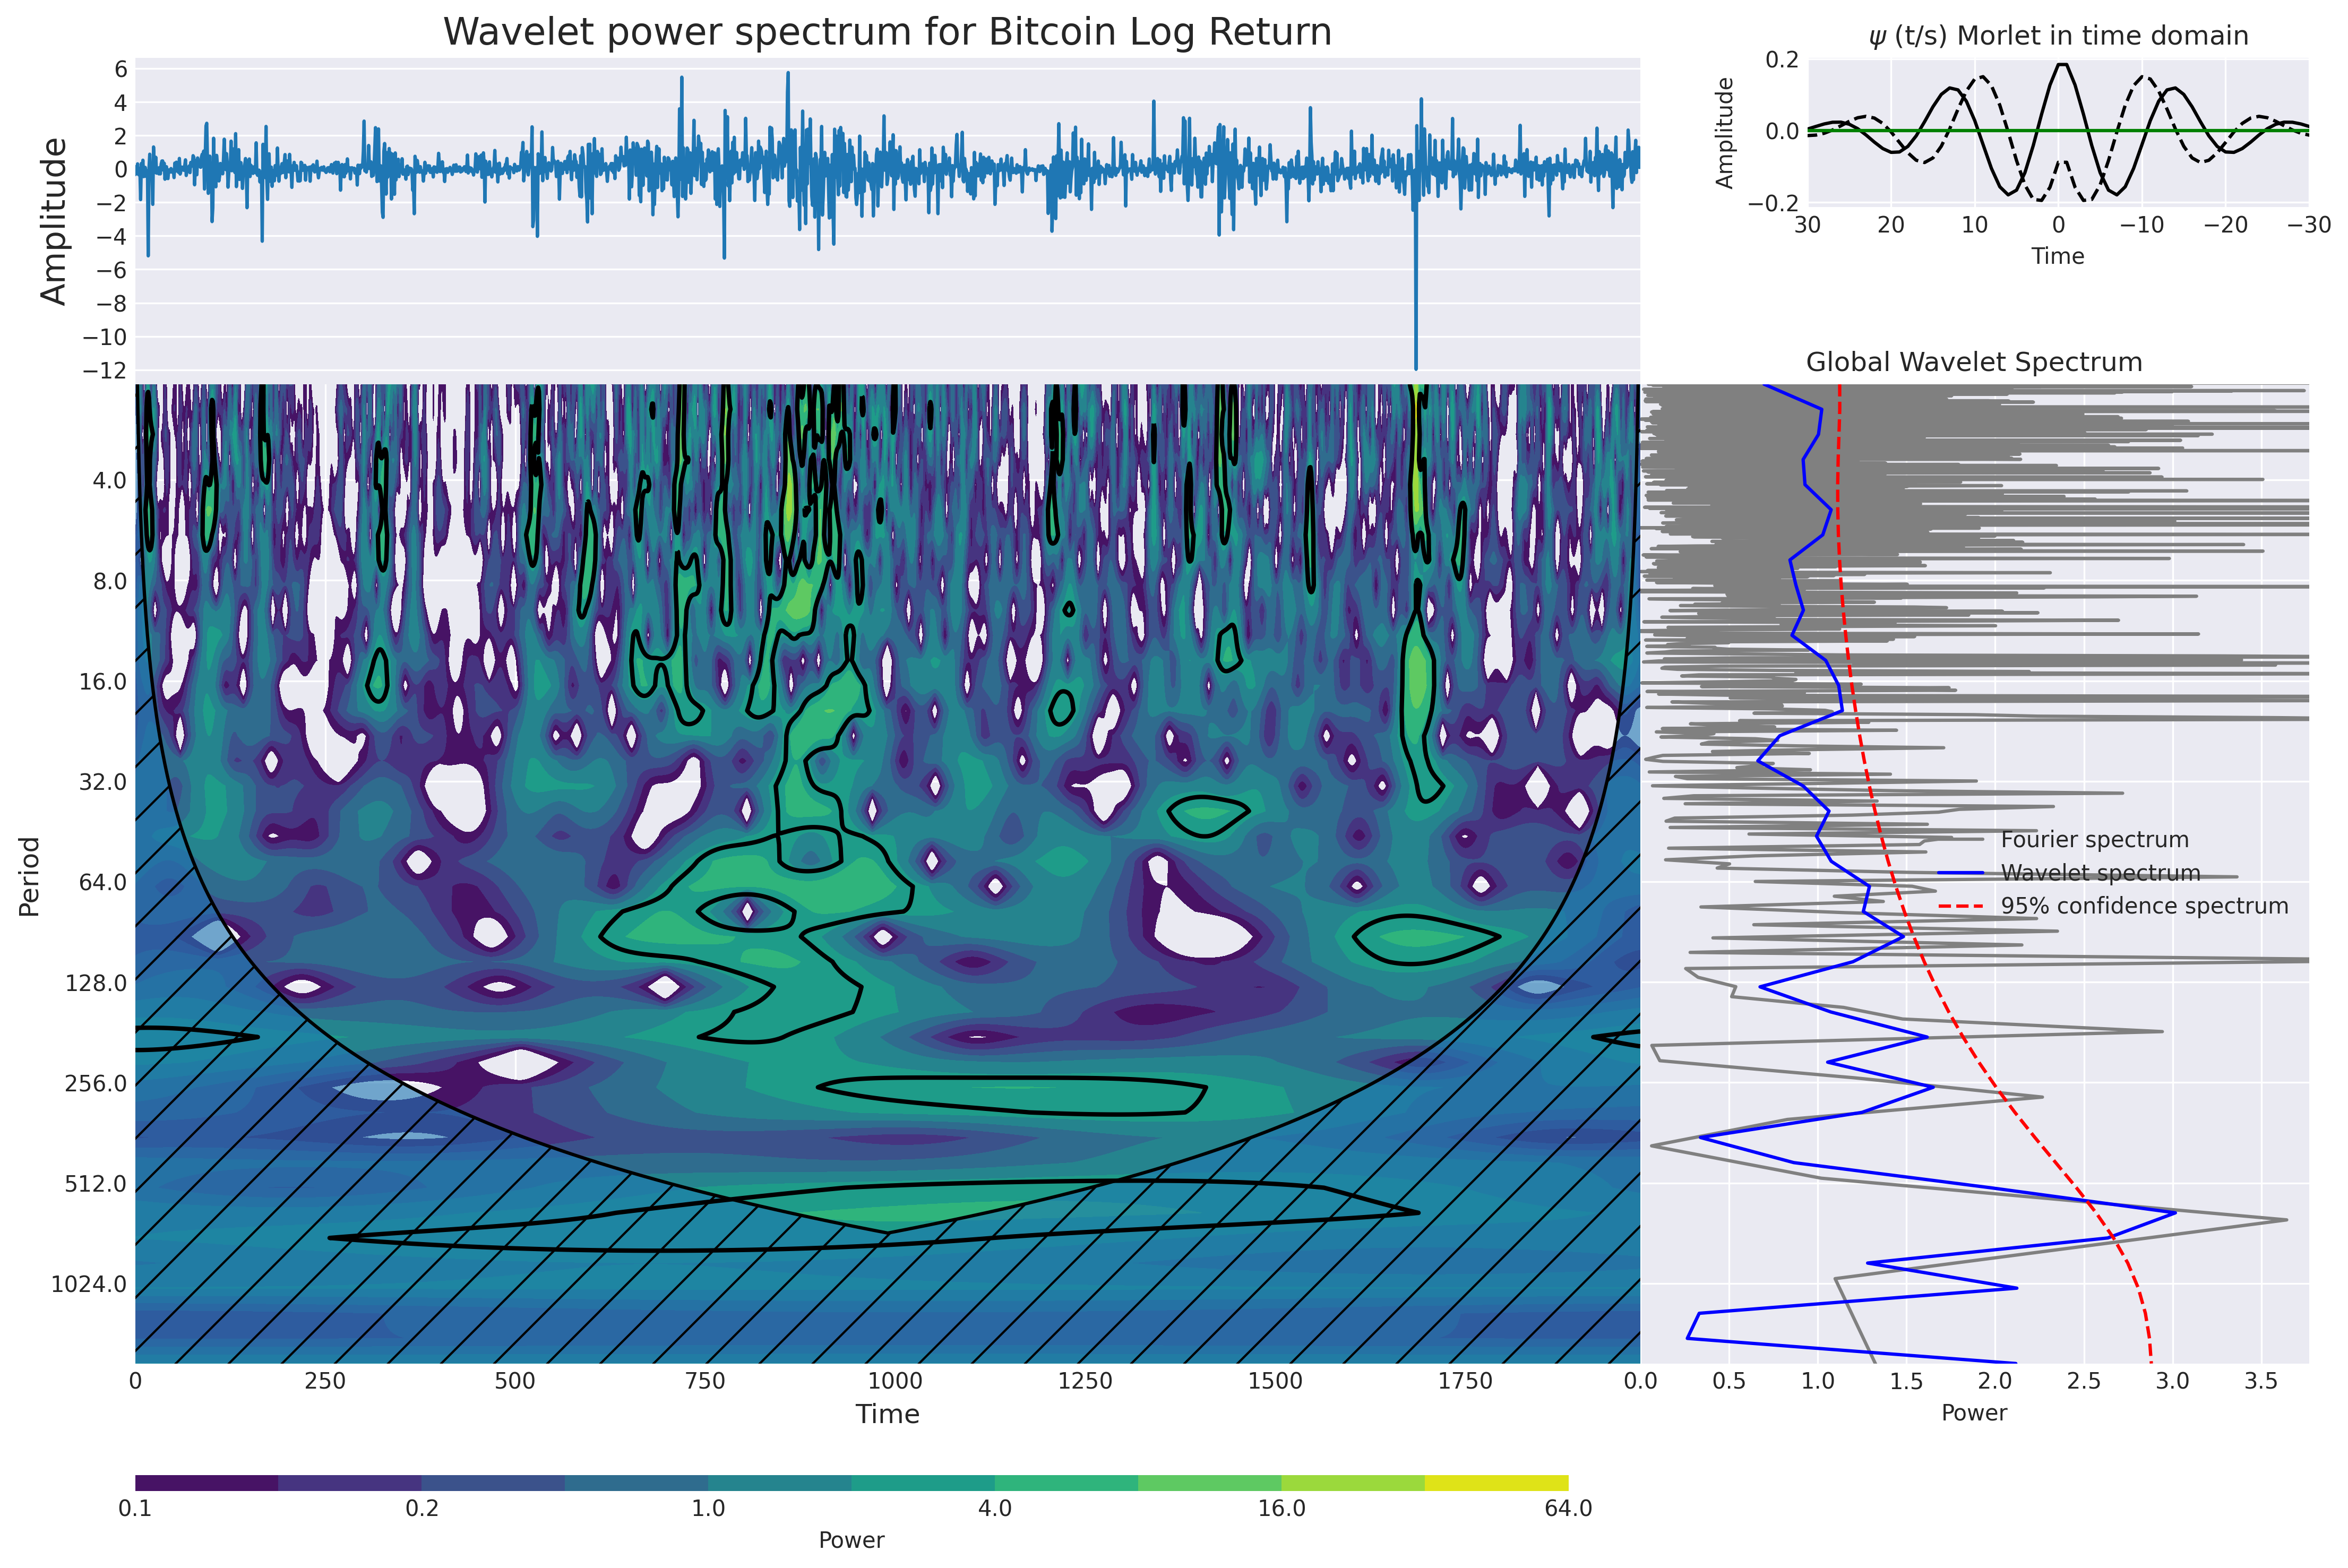

In [ ]:
waipy.wavelet_plot("Wavelet power spectrum for Bitcoin Log Return", time, data_norm, 0.03125, result)